In [3]:
import control as ctrl
from control import TransferFunction as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

import warnings

# Disable specific warning types
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=scipy.linalg.LinAlgWarning)

In [4]:
R_VALUES = [10, 11, 12, 13, 15, 16, 18, 20, 22, 24, 27, 30, 33, 36, 39, 43, 47, 51, 56, 62, 68, 75, 82, 91]

C_VALUES = [10, 11, 12, 13, 15, 16, 18, 20, 22, 24, 27, 30, 33, 36, 39, 43, 47, 51, 56, 62, 68, 75, 82, 91]

In [13]:
def create_control_system(num, den):
    def create_pid_control(x):
        plant = tf(num, den)  

        R = [R_VALUES[x[i]]*10**(x[i+1]) for i in range(0, 8, 2)]
        C = [float(C_VALUES[x[i]])*10**(float(x[i+1])) for i in range(8, 11, 2)]
        
        Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
        Kd = R[3]*R[1]*C[0]/R[2]
        Ki = R[3]/(R[0]*R[2]*C[0])

        #print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')

        pid_controller = tf([Kd, Kp, Ki], [1, 0])

        closed_loop_system = ctrl.feedback(pid_controller * plant)
        time, response = ctrl.step_response(closed_loop_system)

        try:
            info = ctrl.step_info(closed_loop_system)
        except:
            print('Could not get info')
            info = {'SettlingTime': 100, 'RiseTime': 100, 'Overshoot': 100}
        settling_time = info['SettlingTime']
        rise_time = info['RiseTime']
        overshoot = info['Overshoot']

        return settling_time, rise_time, overshoot, time, response
    return create_pid_control

def create_control_system_num(num, den):
    def create_pid_control(x):
        plant = tf(num, den)  

        #print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')

        pid_controller = tf([x[0], x[1], x[2]], [1, 0])

        closed_loop_system = ctrl.feedback(pid_controller * plant)
        time, response = ctrl.step_response(closed_loop_system)

        try:
            info = ctrl.step_info(closed_loop_system)
        except:
            info = {'SettlingTime': 100, 'RiseTime': 100, 'Overshoot': 100}
        settling_time = info['SettlingTime']
        rise_time = info['RiseTime']
        overshoot = info['Overshoot']

        return settling_time, rise_time, overshoot, time, response
    return create_pid_control


def plot_response(time, response):
    info = ctrl.step_info(response, time)
    settling_time = info['SettlingTime']
    rise_time = info['RiseTime']
    overshoot = info['Overshoot']
    plt.plot(time, response)
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.title(f'Step Response of PID-Controlled System. \n ST = {settling_time}, RT = {rise_time}, Overshoot = {overshoot}')
    plt.grid()
    plt.show()

## First Case study

In [14]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as fctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
settling_time = fctrl.Antecedent(np.arange(0, 1, 0.05), 'settling_time')
rise_time = fctrl.Antecedent(np.arange(0, 1, 0.05), 'rise_time')
overshoot = fctrl.Antecedent(np.arange(0, 1, 0.05), 'overshoot')
evaluation = fctrl.Consequent(np.arange(0, 1.25, 0.05), 'evaluation')

# Auto-membership function population is possible with .automf(3, 5, or 7)
settling_time['low'] = fuzz.trimf(settling_time.universe, [0, 0, 0.25])
settling_time['medium'] = fuzz.trimf(settling_time.universe, [0, 0.25, 0.5])
settling_time['high'] = fuzz.trapmf(settling_time.universe, [0.25, 0.5, 1.0, 1.1])

#Auto-membership for the rise time
rise_time['low'] = fuzz.trimf(rise_time.universe, [0, 0, 0.25])
rise_time['medium'] = fuzz.trimf(rise_time.universe, [0, 0.25, 0.5])
rise_time['high'] = fuzz.trimf(rise_time.universe, [0.25, 0.5, 0.75])
rise_time['very_high'] = fuzz.trapmf(rise_time.universe, [0.5, 0.75, 1.0, 1.1])

overshoot['low'] = fuzz.trimf(overshoot.universe, [0, 0, 0.25])
overshoot['medium'] = fuzz.trimf(overshoot.universe, [0, 0.25, 0.5])
overshoot['high'] = fuzz.trimf(overshoot.universe, [0.25, 0.5, 0.75])
overshoot['very_high'] = fuzz.trapmf(overshoot.universe, [0.5, 0.75, 1.0, 1.1])

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
evaluation['very_good'] = fuzz.trimf(evaluation.universe, [0, 0, 0.1])
evaluation['good'] = fuzz.trimf(evaluation.universe, [0, 0.1, 0.25])
evaluation['medium'] = fuzz.trimf(evaluation.universe, [0.1, 0.25, 0.5])
evaluation['bad'] = fuzz.trimf(evaluation.universe, [0.25, 0.5, 0.75])
evaluation['very_bad'] = fuzz.trapmf(evaluation.universe, [0.5, 0.75, 1.0, 1.2])

In [15]:
list_rules = []
# If overshoot is low and rise time is low, then the evaluation is very good
list_rules.append(fctrl.Rule(overshoot['low'] & rise_time['low'], evaluation['very_good']))

#If overshoot is low and rise time is medium, then the evaluation is good
list_rules.append(fctrl.Rule(overshoot['low'] & rise_time['medium'], evaluation['good']))

#If overshoot is medium and rise time is low, then the evaluation is good
list_rules.append(fctrl.Rule(overshoot['medium'] & rise_time['low'], evaluation['good']))

#If overshoot is medium and rise time is medium, then the evaluation is medium
list_rules.append(fctrl.Rule(overshoot['medium'] & rise_time['medium'], evaluation['medium']))

#If overshoot is high, then the evaluation is bad
list_rules.append(fctrl.Rule(overshoot['high'], evaluation['bad']))

#If rise time is high, then the evaluation is bad
list_rules.append(fctrl.Rule(rise_time['high'], evaluation['bad']))

#If overshoot is very high, then the evaluation is very bad
list_rules.append(fctrl.Rule(overshoot['very_high'], evaluation['very_bad']))

#If rise time is very high, then the evaluation is very bad
list_rules.append(fctrl.Rule(rise_time['very_high'], evaluation['very_bad']))

#If settling time is low, then the evaluation is very good
list_rules.append(fctrl.Rule(settling_time['low'], evaluation['very_good']))

#If settling time is medium, then the evaluation is good
list_rules.append(fctrl.Rule(settling_time['medium'], evaluation['good']))

#If settling time is high, then the evaluation is very bad
list_rules.append(fctrl.Rule(settling_time['high'], evaluation['very_bad']))



In [16]:
fuzzy_aggregation = fctrl.ControlSystem(list_rules)

evaluator = fctrl.ControlSystemSimulation(fuzzy_aggregation)

In [19]:
def create_eval_study(num, den, fuzzy_evaluator, scale=[1, 1, 1]):
    plant_control = create_control_system(num, den)
    def eval_study_case(ga_instance, x, x_idx):
        settling_time, rise_time, overshoot, time, response = plant_control(x.astype(int))
        #print(f'Settling time: {settling_time:.2f} s, rise time: {rise_time:.2f} s, overshoot: {overshoot:.2f} %')

        if settling_time/scale[0] > 1 or settling_time == np.nan:
            settling_time = 1
        else:
            settling_time /= scale[0]
        fuzzy_evaluator.input['settling_time'] = settling_time
        if rise_time/scale[1] > 1 or rise_time == np.nan:
            rise_time = 1
        else:
            rise_time /= scale[1]
        fuzzy_evaluator.input['rise_time'] = rise_time
        if overshoot/scale[2] or overshoot == np.nan:
            overshoot = 1
        else:
            overshoot /= scale[2]
        fuzzy_evaluator.input['overshoot'] = overshoot

        fuzzy_evaluator.compute()
    
        return fuzzy_evaluator.output['evaluation']
    return eval_study_case

def create_eval_study_num(num, den, fuzzy_evaluator, scale=[1, 1, 1]):
    plant_control = create_control_system_num(num, den)
    def eval_study_case(ga_instance, x, x_idx):
        settling_time, rise_time, overshoot, time, response = plant_control(x)
        #print(f'Settling time: {settling_time:.2f} s, rise time: {rise_time:.2f} s, overshoot: {overshoot:.2f} %')

        if settling_time/scale[0] > 1:
            settling_time = 1
        else:
            settling_time /= scale[0]
        fuzzy_evaluator.input['settling_time'] = settling_time
        if rise_time/scale[1] > 1:
            rise_time = 1
        else:
            rise_time /= scale[1]
        fuzzy_evaluator.input['rise_time'] = rise_time
        if overshoot/scale[2]:
            overshoot = 1
        else:
            overshoot /= scale[2]
        fuzzy_evaluator.input['overshoot'] = overshoot

        fuzzy_evaluator.compute()
    
        return fuzzy_evaluator.output['evaluation']
    return eval_study_case

Could not get info
Could not get info
Generation = 1
Could not get info
Fitness    = 0.8605263157894737
Could not get info
Change     = 0.8605263157894737
Could not get info
Could not get info
Generation = 2
Could not get info
Fitness    = 0.8605263157894737
Could not get info
Change     = 0.0
Could not get info
Generation = 3
Fitness    = 0.8605263157894737
Change     = 0.0
Could not get info
Could not get info
Generation = 4
Could not get info
Could not get info
Fitness    = 0.8605263157894737
Could not get info
Could not get info
Change     = 0.0
Could not get info
Could not get info
Could not get info
Could not get info
Generation = 5
Could not get info
Could not get info
Fitness    = 0.8605263157894737
Could not get info
Could not get info
Change     = 0.0
Could not get info
Could not get info
Could not get info
Generation = 6
Could not get info
Fitness    = 0.8605263157894737
Could not get info
Change     = 0.0
Could not get info
Generation = 7
Fitness    = 0.8605263157894737
Cha

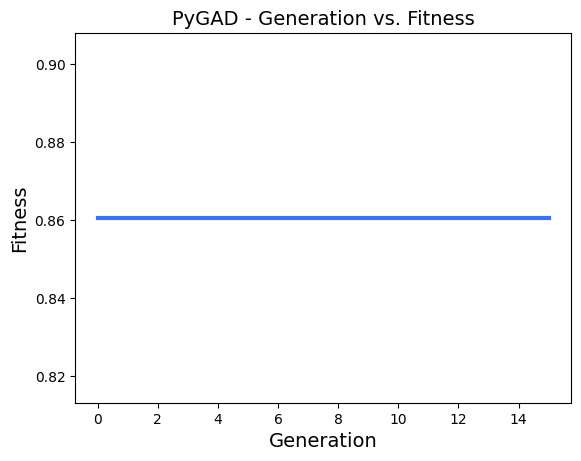

Parameters of the best solution : [20  2 14  2  7  2 12  0 15 -7  7 -7]
Fitness value of the best solution = 0.8605263157894737
Index of the best solution : 0
Best fitness value reached after 0 generations.


In [22]:
import pygad
import numpy

#varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

lower_bound = [0, 2, 0, 2, 0, 2, 0, 2, 0, -12, 0, -12]
upper_bound = [23, 5, 23, 5, 23, 5, 23, 5, 23, -6, 23, -6]

num_generations = 15 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 50

num_genes = 12

last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

num = [4]
den = [1, 0.5, 0]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=create_eval_study(num, den, evaluator, scale=[1, 1, 100]),
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       on_generation=callback_generation,
                       gene_type=int,
                       init_range_high=upper_bound,
                       init_range_low=lower_bound)

# Running the GA to optimize the parameters of the function.
ga_instance.run()

# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# prediction = numpy.sum(numpy.array(function_inputs)*solution)
# print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_1.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Second Case study

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':20,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_2 = None 

num = [1]
#s(s+1)(s+5) = s^3 + 6s^2 + 5s
den = [3, 6, 5, 0]

optimal_ctrl_system = create_control_system(num, den)

for i in range(10):
    model_2=ga(function=create_eval_study(num, den, evaluator, scale=[15, 15, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    model_2.run()

    v = model_2.output_dict['variable'].astype(int)
    R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    Kd = R[3]*R[1]*C[0]/R[2]
    Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
    _, _, _, response, time = optimal_ctrl_system(v)
    plot_response(response, time)


    if results_2 is None:
        results_2 = np.array(model_2.report) 
    else:
        results_2 = np.vstack((results_2,np.array(model_2.report)))

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_2.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Third Case Study

In [ ]:
# Original transfer function coefficients
numerator = [5]
denominator = [15, 8, 1]

# Padé approximation order
order = 2  # Second-order approximation

# Create the Padé approximation
num_approx, den_approx = ctrl.pade(order, 1)  # Use the Padé approximation function

# Create the polynomial transfer function approximation
approx_num = np.convolve(numerator, num_approx)
approx_den = np.convolve(denominator, den_approx)

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':50,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_3 = None 

for i in range(10):
    model_3=ga(function=create_eval_study(approx_num, approx_den, evaluator, scale=[15, 15, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    model_3.run()

    v = model_3.output_dict['variable'].astype(int)
    R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    Kd = R[3]*R[1]*C[0]/R[2]
    Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
    _, _, _, response, time = optimal_ctrl_system(v)
    plot_response(response, time)


    if results_3 is None:
        results_3 = np.array(model_3.report) 
    else:
        results_3 = np.vstack((results_3,np.array(model_3.report)))

In [ ]:
optimal_ctrl_system = create_control_system(approx_num, approx_den)

#Get geneticalgorithm best solution
v = model_3.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Fourth Case study

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':20,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_4 = None 

num = [1, 5, 6]

den = [1, 6, 5, 0]

for i in range(10):
    model_4=ga(function=create_eval_study(num, den, evaluator, scale=[5, 5, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)
    
    model_4.run()
    if results_4 is None:
        results_4 = np.array(model_4.report) 
    else:
        results_4 = np.vstack((results_4,np.array(model_4.report)))

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_4.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Fifth Case study - DC Motor

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 250,\
                   'population_size':25,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_5 = None 

num = [5.5]

den = [0.13, 1, 0]

for i in range(10):
    model_5=ga(function=create_eval_study(num, den, evaluator, scale=[5, 5, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)
    
    model_5.run()

    optimal_ctrl_system = create_control_system(num, den)

    #Get geneticalgorithm best solution
    v = model_5.output_dict['variable'].astype(int)
    R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    Kd = R[3]*R[1]*C[0]/R[2]
    Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
    _, _, _, response, time = optimal_ctrl_system(v)
    plot_response(response, time)

    if results_5 is None:
        results_5 = np.array(model_5.report) 
    else:
        results_5 = np.vstack((results_5,np.array(model_5.report)))

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_5.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)